In [6]:
import pandas as pd

In [12]:
cw_max_name = 'cw20_ampfreebincut10prop'
cw_max_short = 'afbc10p'
bb_max_name = 'bb20_ampfreebincut10prop'
bb_max_short = 'afbc10p'
off_max_name = 'dark_ampfree_alphafix_bincut10prop'
off_max_short = 'afaxbc10p'

In [11]:
def common(df, key):
    s = set(df[key])
    if len(s) > 1:
        raise ValueError("Multiple values for {}".format(key))
    else:
        return s.pop()

    
def float_to_latex(f):
    if np.log10(f) < -15:
        unit = 'aW'
        scale = 1e6
    elif np.log10(f) < -12:
        unit = 'fW'
        scale = 1e3
    else:
        unit = 'pW'
        scale = 1
    scaled = 1e12 * scale * f
    precision = 2 - int(np.floor(np.log10(scaled)))
    format_string = '{{:.{}f}} {{}}'.format(precision)
    return format_string.format(scaled, unit)


def old_white_noise_model(f, series):
    W2 = series.noise_fit_device_noise
    A2 = series.noise_fit_amplifier_noise
    f_c = series.noise_fit_fc
    return W2 / (1 + (f / f_c)**2) + A2


def pink_noise(f, series, key):
    return (white_noise(f, series, key) +
            red_noise(f, series, key) +
            series['{}_amp'.format(key)])

def white_noise(f, series, key):
    W2 = series['{}_white'.format(key)]
    f_c = series['{}_invtau'.format(key)]
    return W2 / (1 + (f / f_c)**2)

def red_noise(f, series, key):
    W2 = series['{}_white'.format(key)]
    f_c = series['{}_invtau'.format(key)]
    f_k = series['{}_fknee'.format(key)]
    alpha = series['{}_alpha'.format(key)]
    return W2 * (f / f_k)**(-alpha) / (1 + (f / f_c)**2)

def plot_noise_and_fit(ax, series, key, f=None):
    if f is None:
        f = series.pca_freq
    ax.plot(series.pca_freq, series.pca_eigvals[1], '-')
    ax.plot()

In [8]:
bb = pd.DataFrame(np.load('broadband.npy'))
cw = pd.DataFrame(np.load('continuous-wave.npy'))
off = pd.DataFrame(np.load('compressor_off.npy')).iloc[0]  # off is a pd.Series

In [49]:
cw_minimum_power = cw[cw.source_power == cw.source_power.min()].iloc[0]
cw_maximum_power = cw[cw.source_power == cw.source_power.max()].iloc[0]

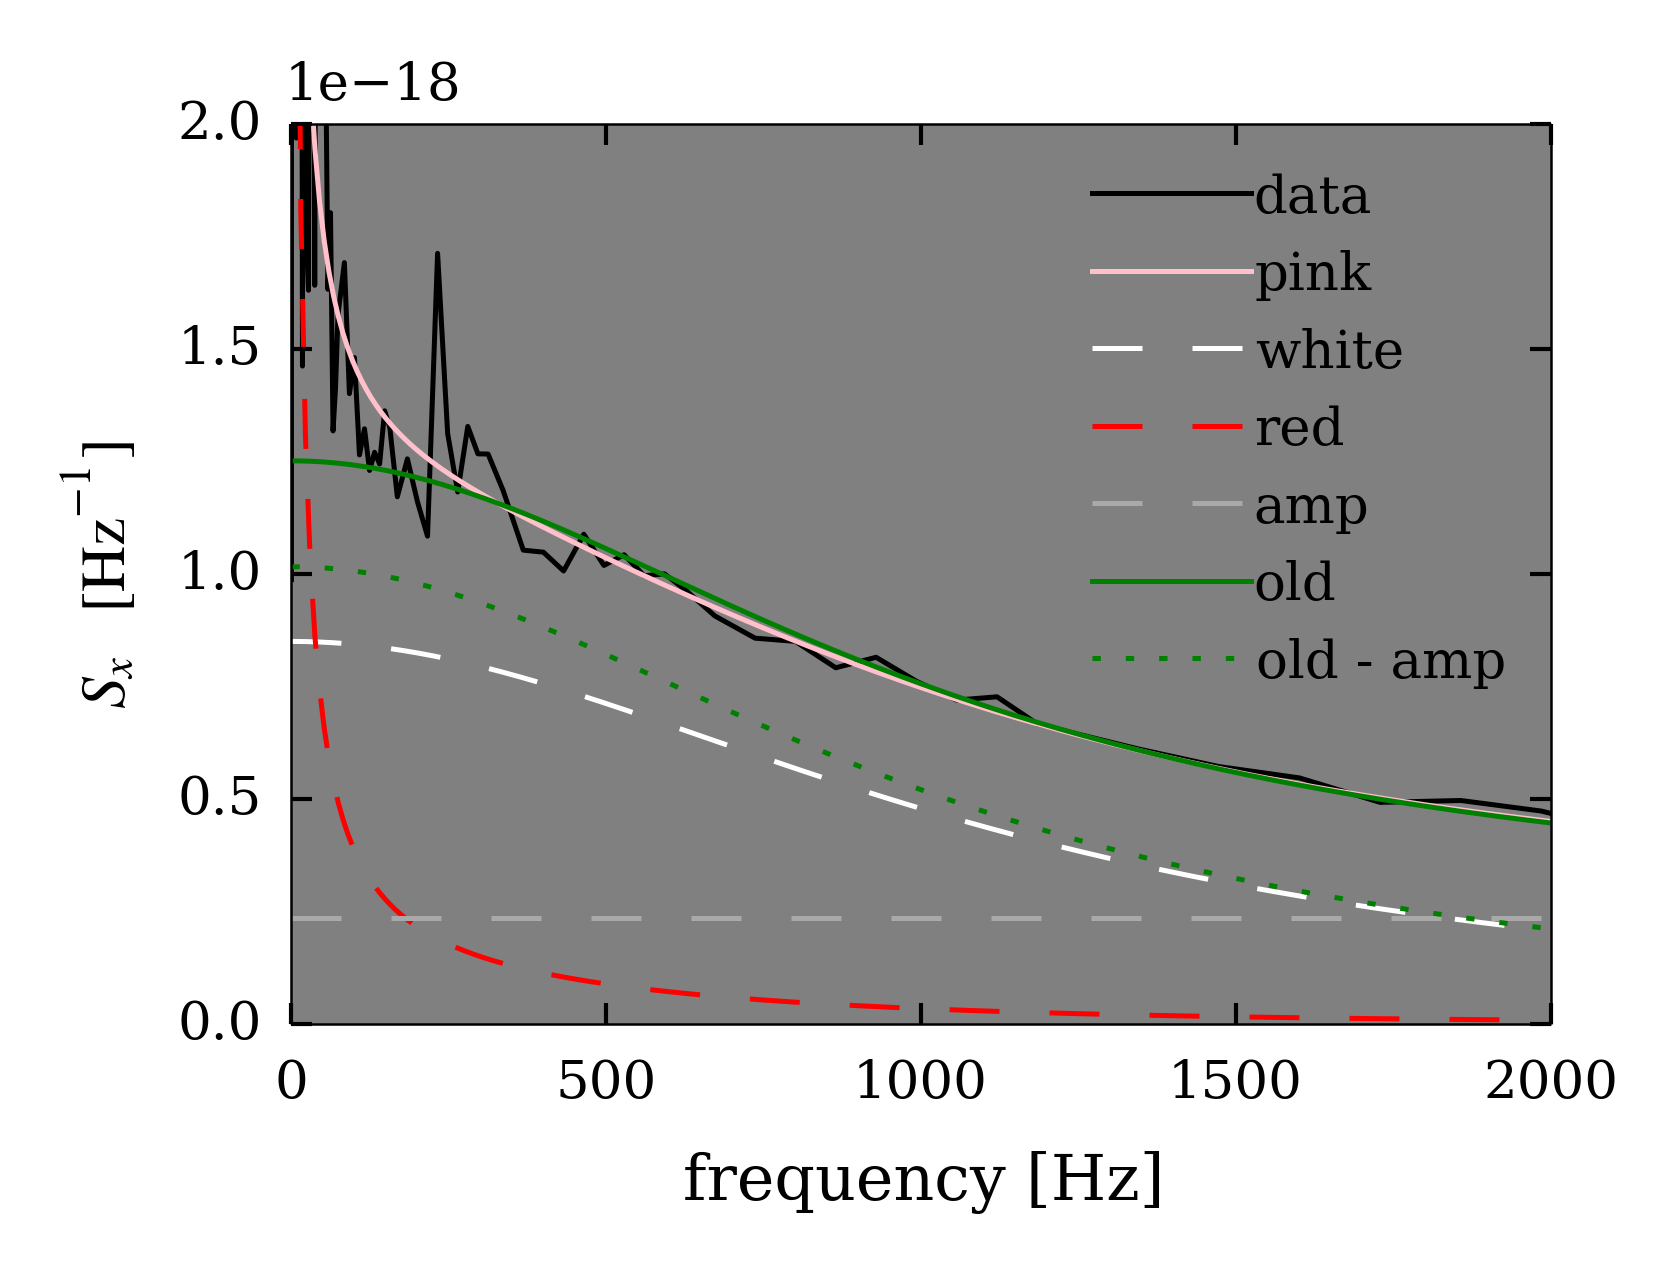

In [57]:
f = np.linspace(cw_minimum_power.pca_freq.min(), cw_minimum_power.pca_freq.max(), 1e3)
fig, ax = plt.subplots()
ax.set_axis_bgcolor('gray')

ax.plot(cw_minimum_power.pca_freq, cw_minimum_power.pca_eigvals[1], '-k', label='data')
ax.plot(f, pink_noise(f, cw_minimum_power, cw_max_name), '-', color='pink', label='pink')
ax.plot(f, white_noise(f, cw_minimum_power, cw_max_name), '--', color='white', label='white')
ax.plot(f, red_noise(f, cw_minimum_power, cw_max_name), '--r', label='red')
ax.axhline(cw_minimum_power['{}_amp'.format(cw_max_name)], color='darkgray', linestyle='--', label='amp')
ax.plot(f, old_white_noise_model(f, cw_minimum_power), '-', color='green', label='old')
ax.plot(f,
        old_white_noise_model(f, cw_minimum_power) - cw_minimum_power.noise_fit_amplifier_noise,
        ':', color='green', label='old - amp')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_x \; [\mathrm{Hz}^{-1}]$')
ax.legend(loc='best')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0, 2e3)
ax.set_ylim(0, 2e-18);

f_k = 38 Hz
f_c = 1135 Hz


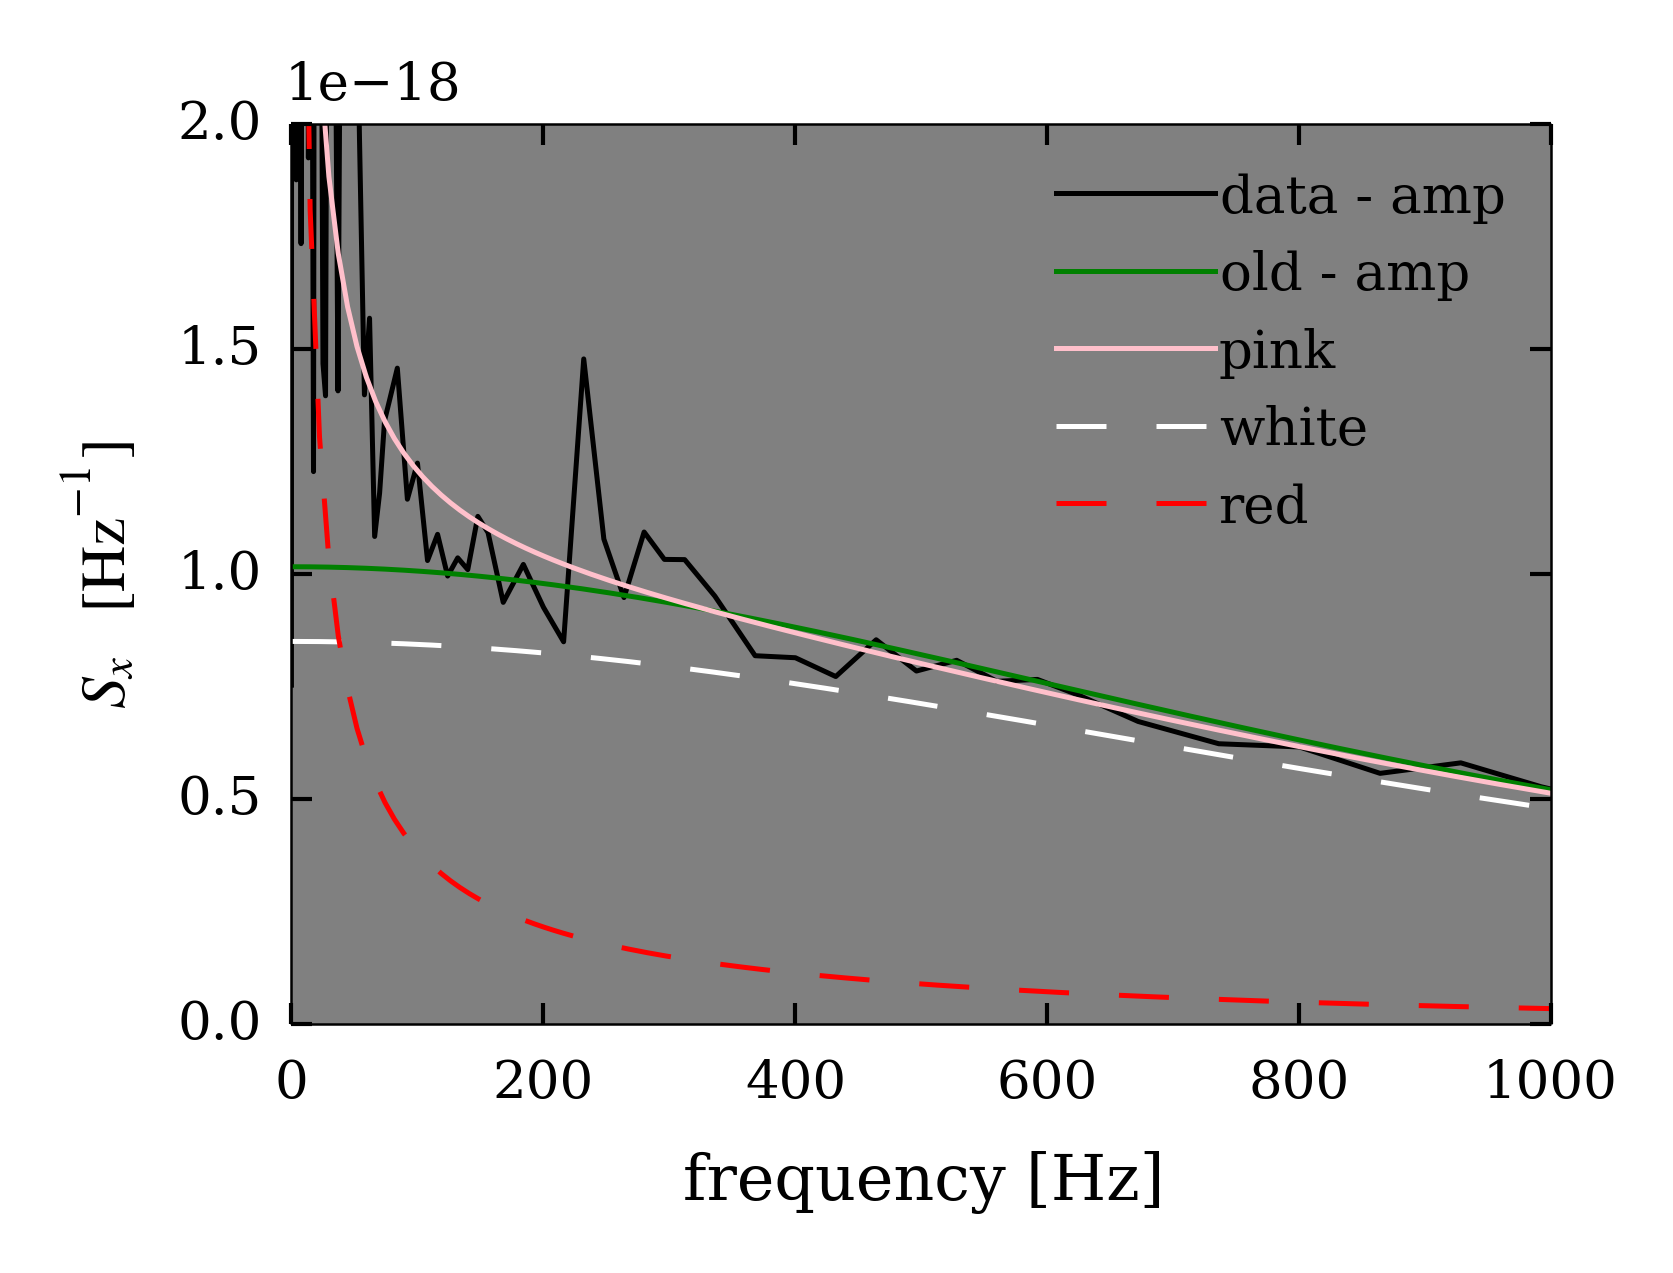

In [48]:
f = np.linspace(cw_minimum_power.pca_freq.min(), cw_minimum_power.pca_freq.max(), 1e3)
fig, ax = plt.subplots()
ax.set_axis_bgcolor('gray')

ax.plot(cw_minimum_power.pca_freq,
        cw_minimum_power.pca_eigvals[1] - cw_minimum_power['{}_amp'.format(cw_max_name)],
        '-k', label='data - amp')
ax.plot(f, old_white_noise_model(f, cw_minimum_power) - cw_minimum_power.noise_fit_amplifier_noise, '-', color='green', label='old - amp')
ax.plot(f,
        red_noise(f, cw_minimum_power, cw_max_name) + white_noise(f, cw_minimum_power, cw_max_name),
        '-', color='pink', label='pink')
ax.plot(f, white_noise(f, cw_minimum_power, cw_max_name), '--', color='white', label='white')
ax.plot(f, red_noise(f, cw_minimum_power, cw_max_name), '--r', label='red')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_x \; [\mathrm{Hz}^{-1}]$')
ax.legend(loc='best')
ax.set_xlim(0, 1e3)
ax.set_ylim(0, 2e-18)
print('f_k = {:.0f} Hz'.format(cw_minimum_power['{}_fknee'.format(cw_max_name)]))
print('f_c = {:.0f} Hz'.format(cw_minimum_power['{}_invtau'.format(cw_max_name)]))